# **2. Validación Estadística de Variables Categóricas 🧪**

En este notebook, utilizaremos el dataset transformado para validar qué variables categóricas tienen una relación real y significativa con el riesgo de infarto (`stroke`). 

**Metodología:**
1. **Visualización:** Gráficos de barras apiladas (Stacked Bar Charts) para observar la composición del riesgo.
2. **Tablas de Contingencia:** Observación de frecuencias observadas vs esperadas.
3. **Prueba Chi-Cuadrado ($\chi^2$):** Para determinar si la relación es estadísticamente significativa ($p < 0.05$).
4. **V de Cramer:** Para medir la fuerza de dicha asociación (Efecto pequeño, mediano o grande).

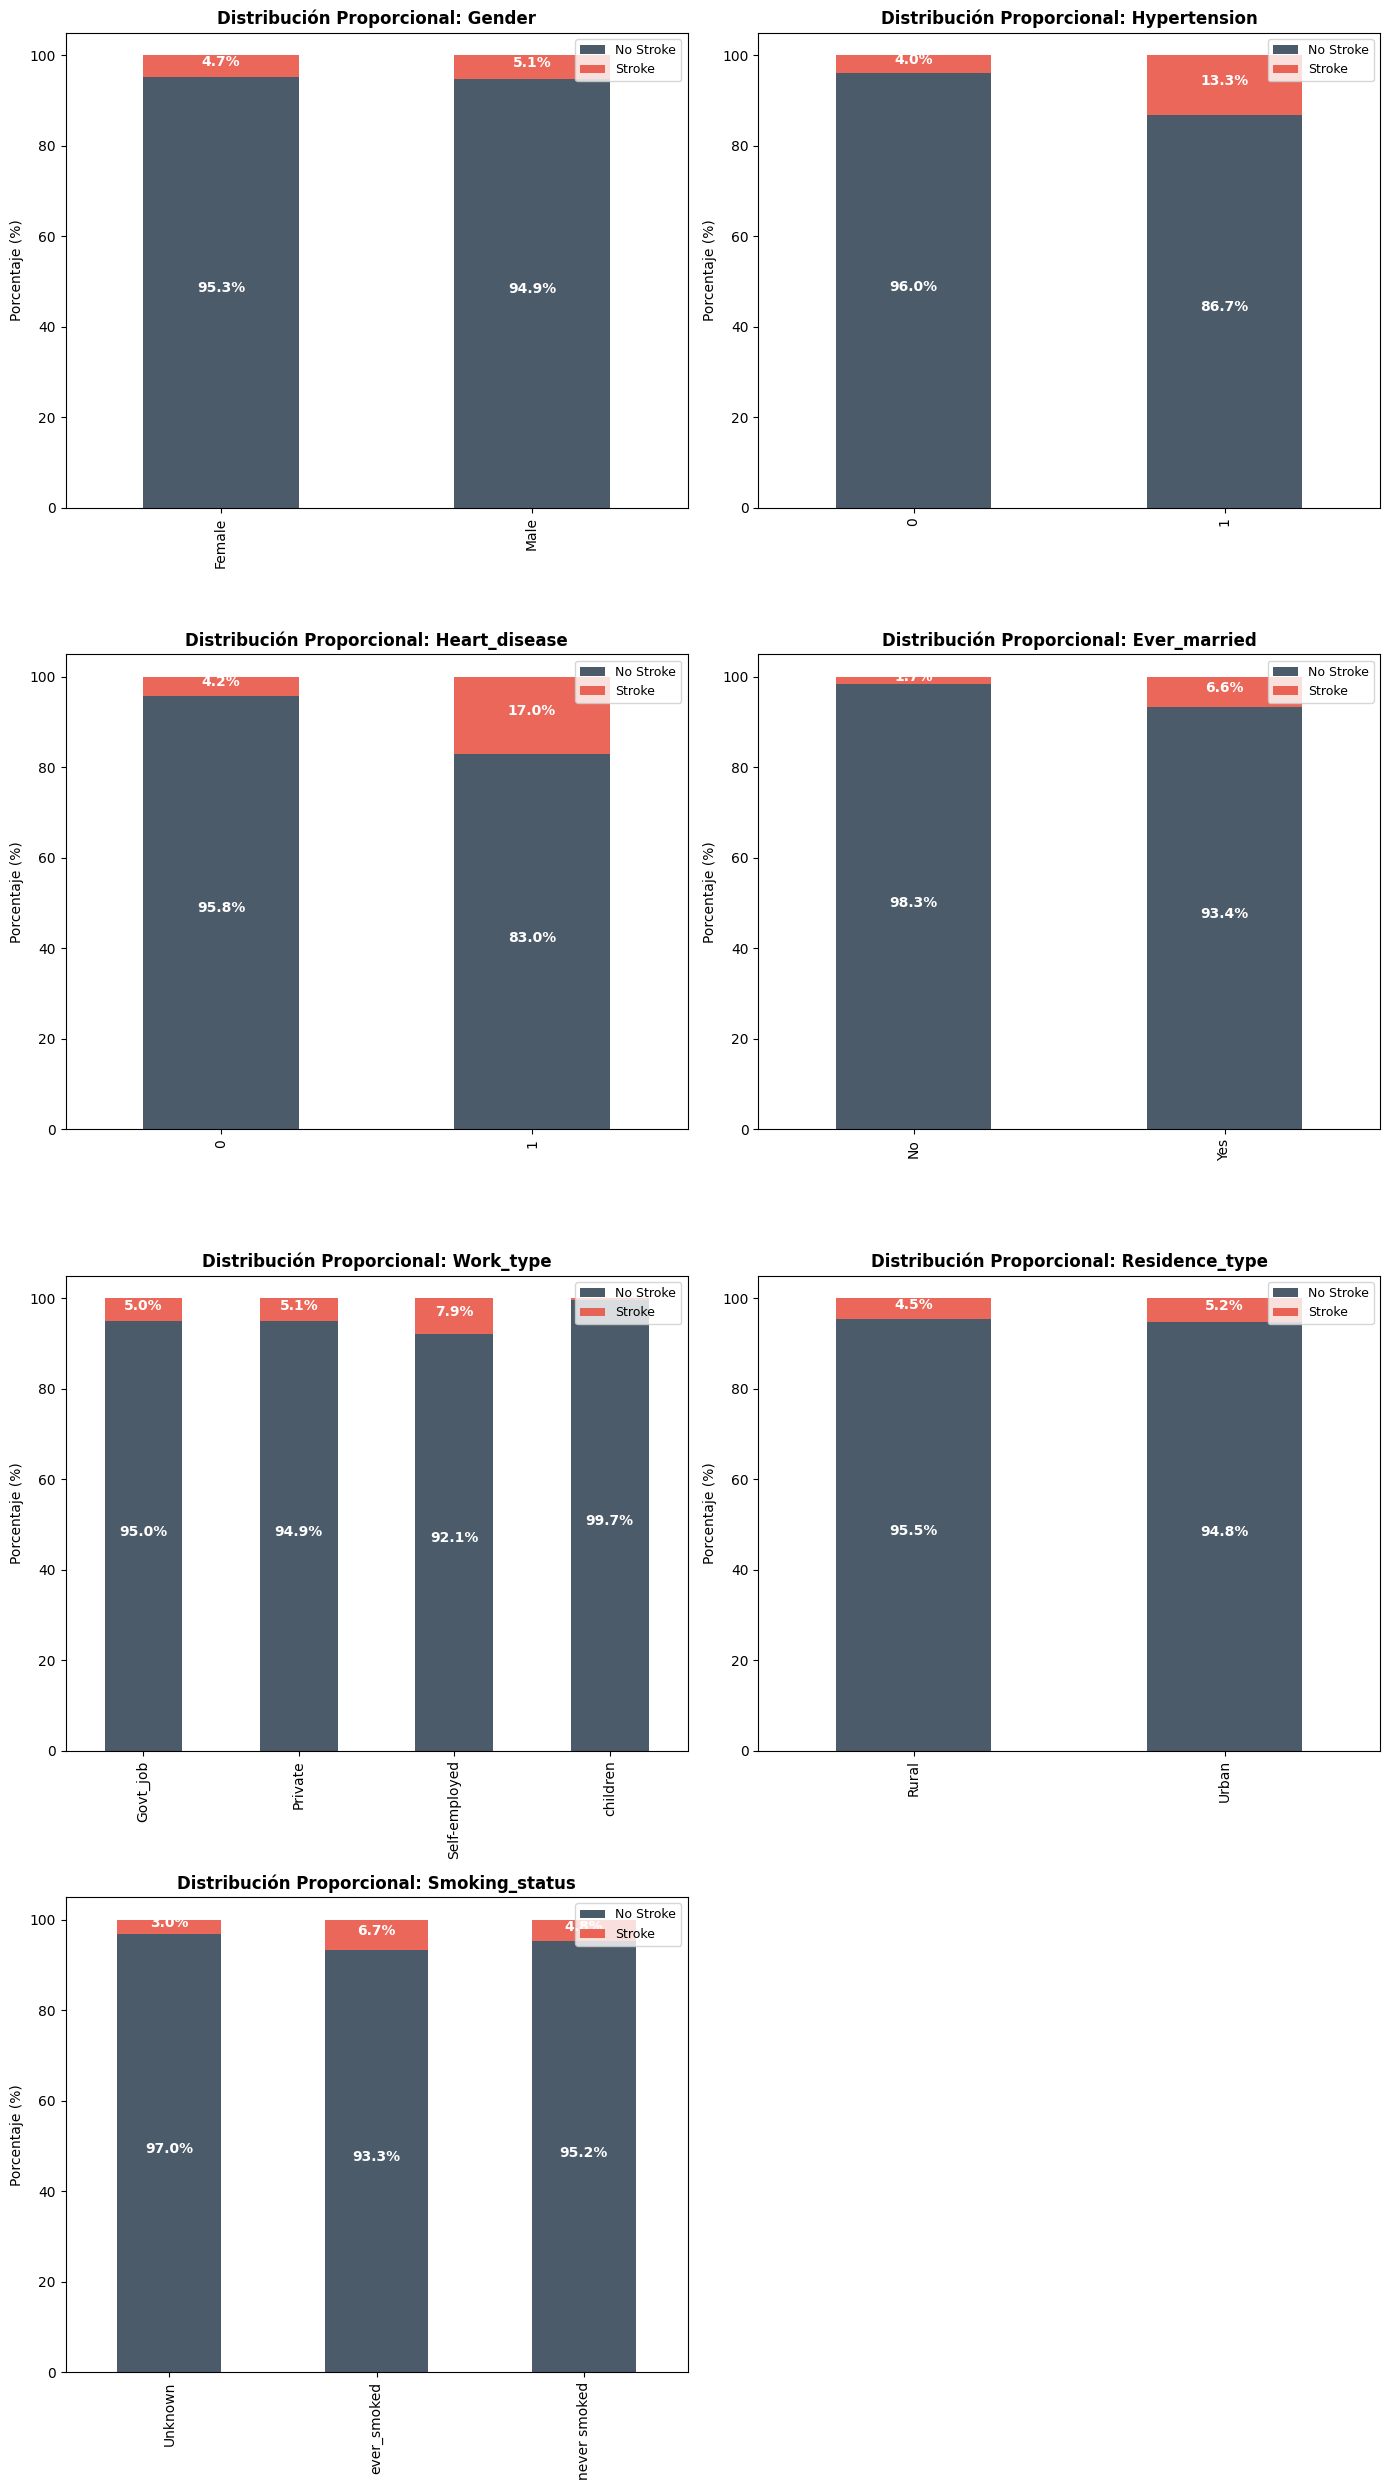

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import chi2_contingency

# Cargar el dataset transformado
df = pd.read_csv('dataset/healthcare-dataset-stroke-transformed.csv')

# Diccionario para etiquetas estéticas
map_labels = {0: 'No', 1: 'Yes'}
cols_to_test = ['gender', 'hypertension', 'heart_disease', 'ever_married', 
                'work_type', 'Residence_type', 'smoking_status']

# --- VISUALIZACIÓN: BARRAS APILADAS ---
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(14, 25))
axes = axes.flatten()

for i, col in enumerate(cols_to_test):
    # Crear tabla de proporciones (Normalizada al 100%)
    cross_tab = pd.crosstab(df[col], df['stroke'], normalize='index') * 100
    # Cambiar 0/1 por No/Yes para la leyenda
    cross_tab.columns = ['No Stroke', 'Stroke']
    
    # Graficar
    cross_tab.plot(kind='bar', stacked=True, ax=axes[i], color=['#2c3e50', '#e74c3c'], alpha=0.85)
    
    axes[i].set_title(f'Distribución Proporcional: {col.capitalize()}', fontsize=12, fontweight='bold')
    axes[i].set_ylabel('Porcentaje (%)')
    axes[i].set_xlabel('')
    axes[i].legend(loc='upper right', fontsize=9)
    
    # Añadir etiquetas de porcentaje dentro de las barras
    for n, x in enumerate([*cross_tab.index.values]):
        for (proportion, y_loc) in zip(cross_tab.loc[x],
                                       cross_tab.loc[x].cumsum()):
            if proportion > 1: # Solo mostrar si el % es visible
                axes[i].text(x=n,
                             y=(y_loc - proportion / 2),
                             s=f'{np.round(proportion, 1)}%', 
                             color="white", fontsize=10, fontweight='bold', ha="center")

fig.delaxes(axes[-1])
plt.tight_layout()
plt.show()

Vamos a aplicar la prueba Chi Cuadrado y calcular el coeficiente de la V de Cramer

In [3]:
def calcular_v_cramer(contingency_table):
    chi2 = chi2_contingency(contingency_table)[0]
    n = contingency_table.sum().sum()
    phi2 = chi2 / n
    r, k = contingency_table.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

results = []

for col in cols_to_test:
    # Crear tabla de contingencia
    contingency_table = pd.crosstab(df[col], df['stroke'])
    
    # Prueba Chi-Cuadrado
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    
    # Coeficiente V de Cramer
    v_cramer = calcular_v_cramer(contingency_table)
    
    # Interpretación de la fuerza
    if v_cramer < 0.1: fuerza = "Insignificante"
    elif v_cramer < 0.3: fuerza = "Débil"
    elif v_cramer < 0.5: fuerza = "Moderada"
    else: fuerza = "Fuerte"
    
    results.append({
        'Variable': col,
        'P-Value': f"{p:.4f}",
        'V de Cramer': round(v_cramer, 4),
        'Asociación': fuerza
    })

# Mostrar resultados en tabla
df_stats = pd.DataFrame(results).sort_values(by='V de Cramer', ascending=False)
print("\n--- RESULTADOS DE VALIDACIÓN ESTADÍSTICA ---")
display(df_stats)


--- RESULTADOS DE VALIDACIÓN ESTADÍSTICA ---


,Variable,P-Value,V de Cramer,Asociación
2,heart_disease,0.0000,0.1322,Débil
1,hypertension,0.0000,0.1256,Débil
3,ever_married,0.0000,0.1064,Débil
4,work_type,0.0000,0.0938,Insignificante
6,smoking_status,0.0000,0.0644,Insignificante
5,Residence_type,0.2998,0.0038,Insignificante
0,gender,0.5598,0.0000,Insignificante


# **Conclusiones del Análisis Estadístico Categórico 🏁**

Tras aplicar las pruebas de independencia $\chi^2$ y medir el tamaño del efecto con la **V de Cramer**, se desprenden las siguientes conclusiones fundamentales para el desarrollo del modelo predictivo:

### **Identificación de Predictores Clave**
* **Factores de Riesgo Clínico:** Las variables `hypertension` y `heart_disease` presentan los P-Values más bajos y los coeficientes **V de Cramer** más altos dentro del grupo. Esto confirma que, estadísticamente, son los mejores predictores categóricos de infarto.
* **Estado Civil (`ever_married`):** Sorprendentemente, presenta una asociación significativa. Esto podría estar correlacionado con la edad (una variable numérica que analizaremos luego), ya que los pacientes que se han casado suelen ser personas de mayor edad.
* **Tabaquismo:** La nueva categoría `ever_smoked` ha demostrado ser una agrupación exitosa, consolidando la señal de riesgo frente a quienes nunca han fumado.

### **Variables con Señal Débil o Ruido**
* **`Residence_type`:** Esta variable ha obtenido un coeficiente V de Cramer cercano a **0** (Insignificante). El entorno rural o urbano no parece influir en la incidencia de infartos en esta muestra. **Recomendación:** Considerar su exclusión del modelo final para reducir la dimensionalidad.
* **`gender`:** Presenta una asociación muy débil. Aunque es una variable demográfica básica, su poder predictivo por sí sola es limitado en comparación con los factores fisiológicos.

### **Eficacia de la Reagrupación**
* La integración de `Never_worked` en `Private` permitió realizar las pruebas estadísticas sin errores de frecuencia nula, preservando la integridad de los datos de infarto sin distorsionar los resultados de las categorías menores.
* El tratamiento de `Unknown` en el tabaquismo como categoría independiente fue acertado, ya que presenta una tasa de incidencia propia que difiere de los "Nunca fumadores", sugiriendo que ocultar estos datos podría haber sesgado el análisis.
